In [125]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from nltk.util import ngrams
import networkx as nx  # pip install networkx if needed

# NLTK tokenizers
nltk.download("punkt")
nltk.download("punkt_tab")

# ---- Load fear lexicon ----
fear_lexicon_path = "/home/blitz/Desktop/NLP/Project/data/fear_lexicon.txt"

fear_lexicon = pd.read_csv(fear_lexicon_path, header=None, names=["word"])
fear_lexicon["word"] = fear_lexicon["word"].str.lower().str.strip()
fear_lexicon = fear_lexicon[fear_lexicon["word"] != ""].drop_duplicates()

fear_words = set(fear_lexicon["word"])
print(f"Loaded {len(fear_words)} fear-related entries.")


Loaded 242 fear-related entries.


[nltk_data] Downloading package punkt to /home/blitz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/blitz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [127]:


pet_path = "/home/blitz/Desktop/NLP/Project/data/PetSemetary_updated.txt"
sh_path  = "/home/blitz/Desktop/NLP/Project/data/TheShining_updated.txt"

with open(pet_path, "r", encoding="utf-8") as f:
    pet_text = f.read()

with open(sh_path, "r", encoding="utf-8") as f:
    sh_text = f.read()

print("Raw text loaded.")
print("Pet Sematary length:", len(pet_text))
print("The Shining length:", len(sh_text))


def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s']", " ", text)  # keep letters, apostrophes, spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

pet_clean = clean_text(pet_text)
sh_clean  = clean_text(sh_text)

print("Cleaning complete.")


Raw text loaded.
Pet Sematary length: 813927
The Shining length: 897063
Cleaning complete.


In [128]:
# ---- Tokenize into word sequences ----
pet_tokens = word_tokenize(pet_clean)
sh_tokens  = word_tokenize(sh_clean)

print("Pet Sematary tokens:", len(pet_tokens))
print("The Shining tokens:", len(sh_tokens))



Pet Sematary tokens: 153210
The Shining tokens: 165584


In [141]:


BAD_TOKENS = {
    "'s", "s",
    "'m", "m",
    "'re", "re",
    "'ll", "ll",
    "'ve", "ve",
    "n't"
}

pet_tokens_clean = [t for t in pet_tokens if t.lower() not in BAD_TOKENS]
sh_tokens_clean  = [t for t in sh_tokens  if t.lower() not in BAD_TOKENS]

print("Original Pet tokens :", len(pet_tokens), "→ cleaned:", len(pet_tokens_clean))
print("Original Shining    :", len(sh_tokens), "→ cleaned:", len(sh_tokens_clean))



Original Pet tokens : 153210 → cleaned: 150954
Original Shining    : 165584 → cleaned: 162235


In [144]:
def fear_ngrams(tokens, fear_set, n=2):
    """
    Return a Counter of n-grams (as strings) that contain
    at least one fear word.
    """
    counts = Counter()
    for gram in ngrams(tokens, n):
        gram_lower = tuple(w.lower() for w in gram)
        if any(w in fear_set for w in gram_lower):
            counts[" ".join(gram_lower)] += 1
    return counts

# 2-grams and 3-grams for each novel
pet_bi  = fear_ngrams(pet_tokens_clean, fear_words, n=2)
pet_tri = fear_ngrams(pet_tokens_clean, fear_words, n=3)

sh_bi   = fear_ngrams(sh_tokens_clean, fear_words, n=2)
sh_tri  = fear_ngrams(sh_tokens_clean, fear_words, n=3)

print("2-gram and 3-gram fear contexts extracted.")


2-gram and 3-gram fear contexts extracted.


In [145]:
TOP_N = 15  # how many rows to show

def top_collocation_table(counter, title):
    top_items = counter.most_common(TOP_N)
    df = pd.DataFrame(top_items, columns=["n-gram", "count"])
    print("\n" + "="*70)
    print(title)
    print("="*70)
    display(df)
    return df

# ---- Pet Sematary ----
pet_bi_df  = top_collocation_table(pet_bi,  "Pet Sematary — Top 2-gram fear collocations")
pet_tri_df = top_collocation_table(pet_tri, "Pet Sematary — Top 3-gram fear collocations")

# ---- The Shining ----
sh_bi_df   = top_collocation_table(sh_bi,  "The Shining — Top 2-gram fear collocations")
sh_tri_df  = top_collocation_table(sh_tri, "The Shining — Top 3-gram fear collocations")



Pet Sematary — Top 2-gram fear collocations


,n-gram,count
0,death of,14
1,of death,12
2,the death,11
3,the dying,9
4,was afraid,8
5,i scared,7
6,was screaming,6
7,scared and,6
8,death was,6
9,that death,6



Pet Sematary — Top 3-gram fear collocations


,n-gram,count
0,the death of,10
1,death of victor,5
2,he was afraid,5
3,that death was,4
4,the dying man,4
5,to worry about,4
6,she was screaming,3
7,was wary of,3
8,facts of death,3
9,degree of fever,3



The Shining — Top 2-gram fear collocations


,n-gram,count
0,worried about,15
1,to death,13
2,an accident,11
3,worry about,9
4,a ghost,9
5,was scared,9
6,was afraid,8
7,red death,7
8,to worry,7
9,wound up,7



The Shining — Top 3-gram fear collocations


,n-gram,count
0,the red death,7
1,to worry about,6
2,red death held,6
3,death held sway,6
4,had been frightened,4
5,have an accident,4
6,like scary pictures,4
7,he was afraid,4
8,it scared him,4
9,got a ghost,3


In [132]:
def build_fear_cooc_graph(tokens, fear_set, window=5, min_weight=2):
    """
    Build an undirected graph:
    - nodes: fear words (from lexicon)
    - edge (w1, w2): they appear within `window` fear tokens of each other
    - weight: number of co-occurrences
    """
    # keep only tokens that are in the fear lexicon
    fear_seq = [w.lower() for w in tokens if w.lower() in fear_set]

    pair_counts = Counter()

    for i in range(len(fear_seq)):
        w1 = fear_seq[i]
        # look ahead within window
        for j in range(i + 1, min(i + window + 1, len(fear_seq))):
            w2 = fear_seq[j]
            if w1 == w2:
                continue
            edge = tuple(sorted((w1, w2)))
            pair_counts[edge] += 1

    G = nx.Graph()
    for (u, v), w in pair_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    return G

G_pet = build_fear_cooc_graph(pet_tokens, fear_words, window=5, min_weight=2)
G_sh  = build_fear_cooc_graph(sh_tokens,  fear_words, window=5, min_weight=2)

print("Pet Sematary graph:", G_pet.number_of_nodes(), "nodes,", G_pet.number_of_edges(), "edges")
print("The Shining graph:",  G_sh.number_of_nodes(),  "nodes,", G_sh.number_of_edges(),  "edges")


Pet Sematary graph: 126 nodes, 756 edges
The Shining graph: 136 nodes, 861 edges


In [133]:
def plot_fear_graph(G, title):
    plt.figure(figsize=(8, 8))

    # spring layout for clearer structure
    pos = nx.spring_layout(G, k=0.8, iterations=80, seed=42)

    node_size = 500  # fixed size

    if G.number_of_edges() > 0:
        weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
        edge_widths = 1 + (weights / weights.max()) * 2
    else:
        edge_widths = 1

    nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="#4B8BBE")
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

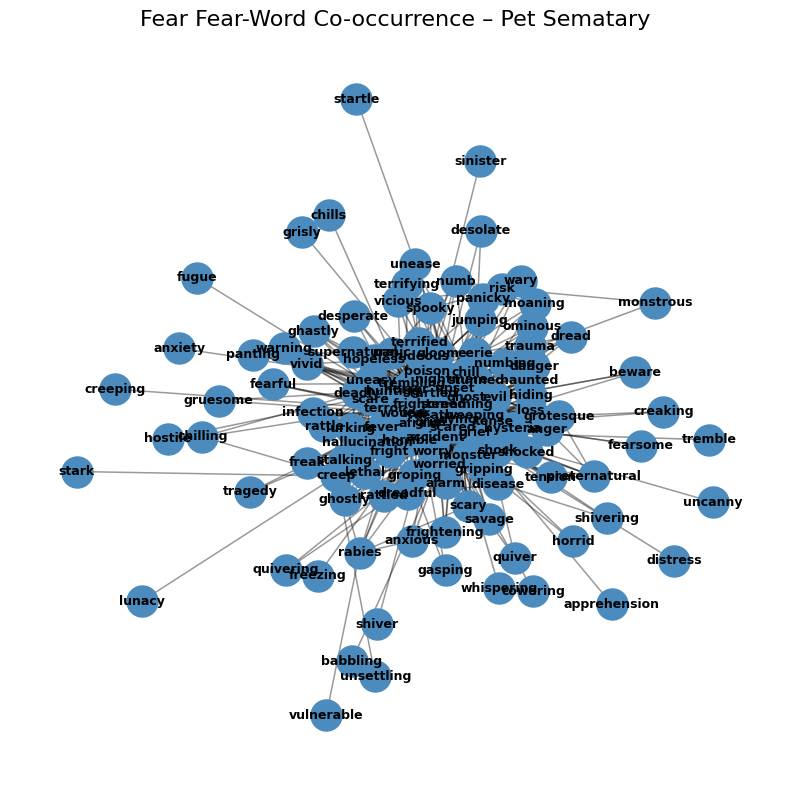

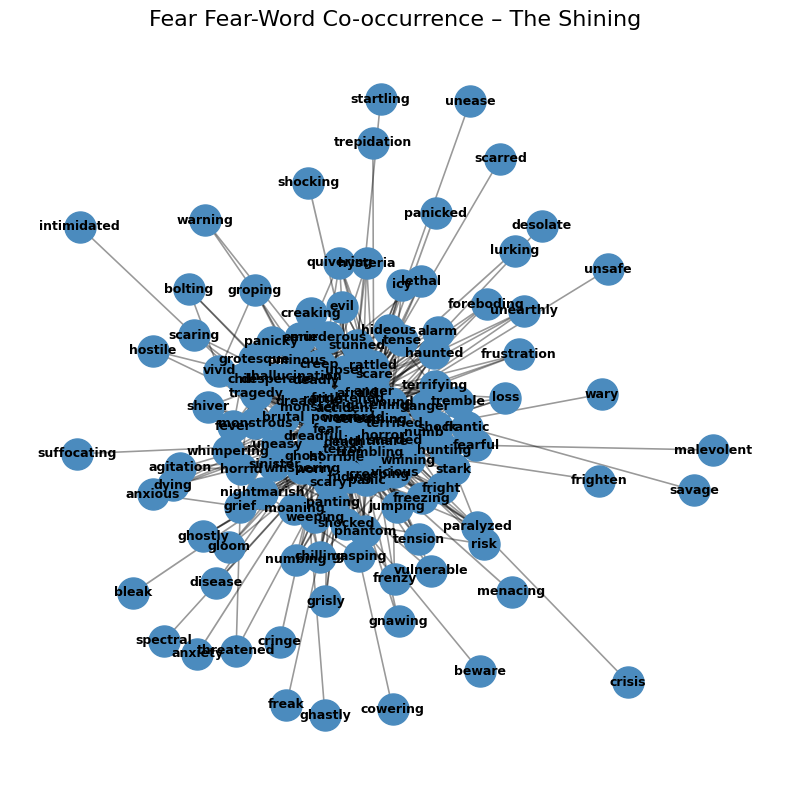

In [134]:
plot_fear_graph(G_pet, "Fear Fear-Word Co-occurrence – Pet Sematary")
plot_fear_graph(G_sh,  "Fear Fear-Word Co-occurrence – The Shining")

In [135]:


# fear_words (lexicon), pet_tokens, sh_tokens already exist

# Filter tokens that are in the fear lexicon
pet_fear_tokens = [w.lower() for w in pet_tokens if w.lower() in fear_words]
sh_fear_tokens  = [w.lower() for w in sh_tokens  if w.lower() in fear_words]

pet_fear_freq = pd.Series(pet_fear_tokens).value_counts()
sh_fear_freq  = pd.Series(sh_fear_tokens).value_counts()

TOP_N = 30

pet_top_words = set(pet_fear_freq.nlargest(TOP_N).index)
sh_top_words  = set(sh_fear_freq.nlargest(TOP_N).index)

print("Pet Sematary top fear words:", len(pet_top_words))
print("The Shining top fear words:", len(sh_top_words))


Pet Sematary top fear words: 30
The Shining top fear words: 30


In [136]:


def build_top_fear_graph(tokens, fear_set, top_words, window=5, min_weight=2):
    """
    Build graph where:
    - nodes: top fear words (intersection of fear_set and top_words)
    - edge: two top fear words appear within `window` fear tokens
    """
    # keep only fear tokens that are in top_words
    fear_seq = [w.lower() for w in tokens
                if (w.lower() in fear_set) and (w.lower() in top_words)]

    pair_counts = Counter()

    for i in range(len(fear_seq)):
        w1 = fear_seq[i]
        for j in range(i + 1, min(i + window + 1, len(fear_seq))):
            w2 = fear_seq[j]
            if w1 == w2:
                continue
            edge = tuple(sorted((w1, w2)))
            pair_counts[edge] += 1

    G = nx.Graph()
    for (u, v), w in pair_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    return G

G_pet_top = build_top_fear_graph(pet_tokens, fear_words, pet_top_words,
                                 window=5, min_weight=2)
G_sh_top  = build_top_fear_graph(sh_tokens,  fear_words, sh_top_words,
                                 window=5, min_weight=2)

print("Pet Sematary (top 30) :", G_pet_top.number_of_nodes(), "nodes,", G_pet_top.number_of_edges(), "edges")
print("The Shining (top 30)  :", G_sh_top.number_of_nodes(),  "nodes,", G_sh_top.number_of_edges(),  "edges")


Pet Sematary (top 30) : 30 nodes, 323 edges
The Shining (top 30)  : 30 nodes, 359 edges


In [137]:


from networkx.algorithms.community import greedy_modularity_communities

def plot_clustered_fear_graph(G, title):
    if G.number_of_nodes() == 0:
        print("Graph is empty:", title)
        return

    # --- community detection ---
    communities = list(greedy_modularity_communities(G))
    # map node -> community index
    comm_index = {}
    for i, comm in enumerate(communities):
        for node in comm:
            comm_index[node] = i

    # color map for communities
    num_comms = len(communities)
    cmap = plt.get_cmap("tab10")  # up to 10 distinct colors; cycles afterwards
    node_colors = [cmap(comm_index[n] % 10) for n in G.nodes()]

    # node sizes by degree
    deg = dict(G.degree())
    node_sizes = [300 + deg[n] * 80 for n in G.nodes()]

    # edge widths by weight
    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    edge_widths = 1 + (weights / weights.max()) * 2

    # layout
    pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42)

    plt.figure(figsize=(9, 9))
    nx.draw_networkx_edges(G, pos, alpha=0.35, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


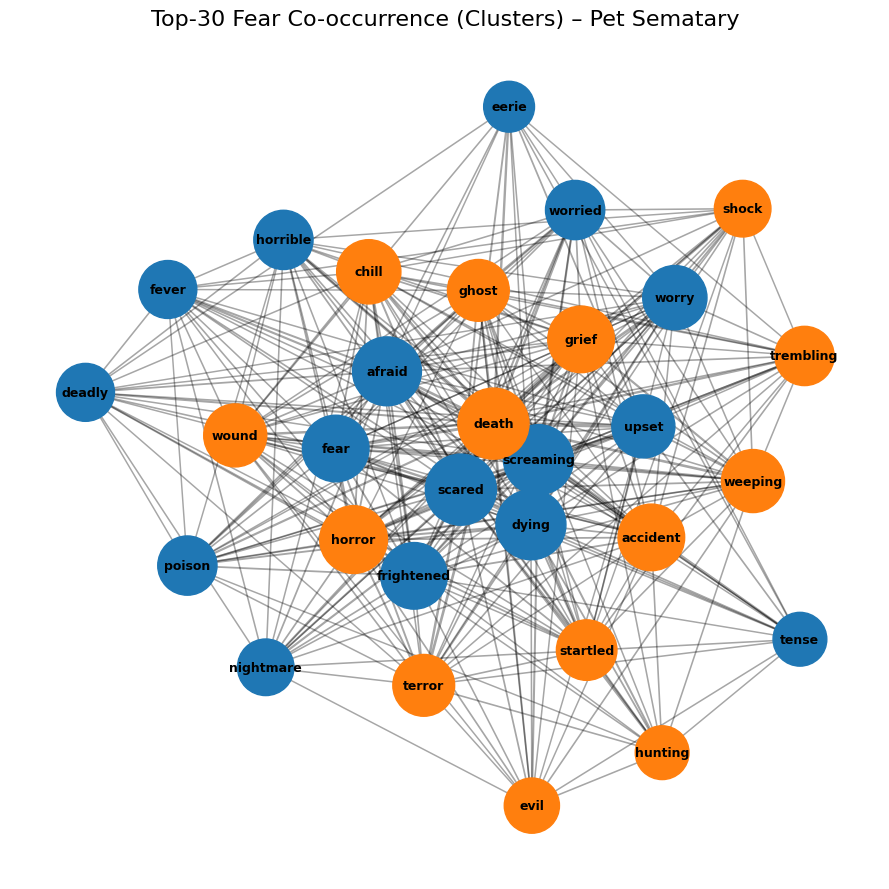

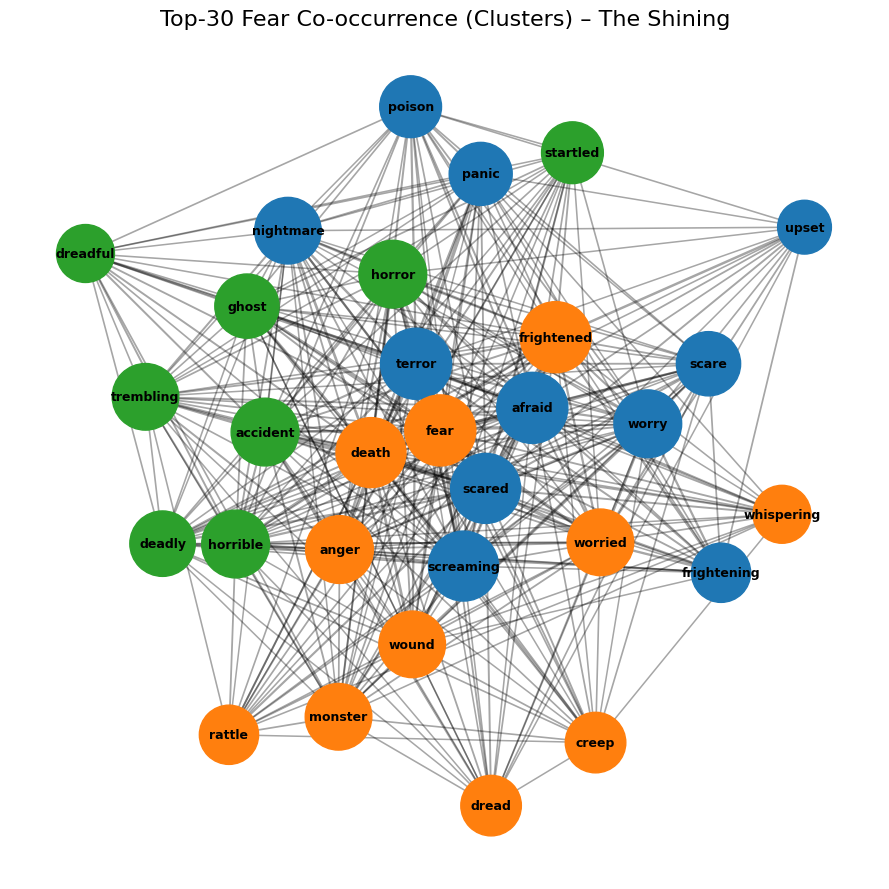

In [138]:


plot_clustered_fear_graph(G_pet_top, "Top-30 Fear Co-occurrence (Clusters) – Pet Sematary")
plot_clustered_fear_graph(G_sh_top,  "Top-30 Fear Co-occurrence (Clusters) – The Shining")
